In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment=None
pd.options.display.max_columns=9999

In [4]:
train_df = pd.read_csv('train.csv')

In [5]:
train_df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
3,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
4,2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,17.133333,55.03,6.300000,85.766667,17.133333,41.260000,18.1,48.590000,17.000000,45.29,6.016667,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


In [6]:
temp_cols = ["T1","T2","T3","T4","T5","T6","T7","T8","T9"]

#humidity sensor columns
rho_cols = ["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]

#weather data
weather_cols = ["T_out", "Tdewpoint","RH_out","Press_mm_hg","Windspeed","Visibility"]

target = ["Appliances"]

In [19]:
output = train_df[target]
input_vars = train_df[temp_cols + rho_cols + weather_cols]

In [21]:
input_vars.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed,Visibility
0,19.89,19.2,19.79,19.000000,17.166667,7.026667,17.200000,18.2,17.033333,47.596667,44.790000,44.730000,45.566667,55.20,84.256667,41.626667,48.900000,45.53,6.600000,5.3,92.0,733.5,7.000000,63.000000
1,19.89,19.2,19.79,19.000000,17.166667,6.833333,17.200000,18.2,17.066667,46.693333,44.722500,44.790000,45.992500,55.20,84.063333,41.560000,48.863333,45.56,6.483333,5.2,92.0,733.6,6.666667,59.166667
2,19.89,19.2,19.79,18.926667,17.166667,6.560000,17.200000,18.2,17.000000,46.300000,44.626667,44.933333,45.890000,55.09,83.156667,41.433333,48.730000,45.50,6.366667,5.1,92.0,733.7,6.333333,55.333333
3,19.89,19.2,19.79,18.890000,17.200000,6.366667,17.200000,18.1,17.000000,46.333333,44.530000,45.000000,45.530000,55.09,84.893333,41.230000,48.590000,45.40,6.133333,4.9,92.0,733.9,5.666667,47.666667
4,19.89,19.2,19.79,18.890000,17.133333,6.300000,17.133333,18.1,17.000000,46.026667,44.500000,44.933333,45.730000,55.03,85.766667,41.260000,48.590000,45.29,6.016667,4.8,92.0,734.0,5.333333,43.833333


In [22]:
input_vars.describe()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed,Visibility
count,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000,14803.000000
mean,21.684167,20.342506,22.262628,20.855433,19.585043,7.921003,20.263911,22.029160,19.480759,40.271439,40.418056,39.249149,39.030359,50.961769,54.623669,35.387456,42.924554,41.542065,7.413018,3.756859,79.734122,755.502983,4.034470,38.330141
std,1.607780,2.191842,2.013785,2.044786,1.847725,6.103785,2.115320,1.958897,2.017733,3.981741,4.066223,3.252755,4.339783,9.046095,31.203920,5.118179,5.242376,4.150839,5.323843,4.200297,14.955609,7.427684,2.436870,11.812780
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.065000,15.390000,16.306667,14.890000,27.023333,20.893333,28.766667,27.660000,29.856667,1.000000,23.200000,29.600000,29.166667,-5.000000,-6.600000,24.000000,729.300000,0.000000,1.000000
25%,20.730000,18.823333,20.790000,19.500000,18.265000,3.656667,18.700000,20.790000,18.000000,37.361667,37.900000,36.900000,35.530000,45.400000,30.098333,31.500000,39.060000,38.500000,3.666667,0.900000,70.000000,750.866667,2.000000,29.000000
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.295000,20.033333,22.128571,19.390000,39.656667,40.500000,38.530000,38.400000,49.090000,55.296667,34.823333,42.363333,40.863333,6.900000,3.450000,83.666667,756.100000,3.666667,40.000000
75%,22.600000,21.500000,23.290000,22.100000,20.600000,11.245000,21.600000,23.390000,20.600000,43.090000,43.290000,41.761667,42.130000,53.663333,83.326667,39.002500,46.561667,44.363333,10.400000,6.533333,91.666667,760.933333,5.500000,40.000000
max,26.260000,29.856667,29.236000,26.200000,25.745000,28.290000,26.000000,27.230000,24.500000,63.360000,56.026667,50.163333,51.063333,95.953889,99.900000,51.400000,58.780000,53.326667,25.966667,15.500000,100.000000,772.300000,13.500000,66.000000


In [27]:
output.values

array([[ 60],
       [ 60],
       [ 50],
       ...,
       [ 90],
       [420],
       [430]], dtype=int64)

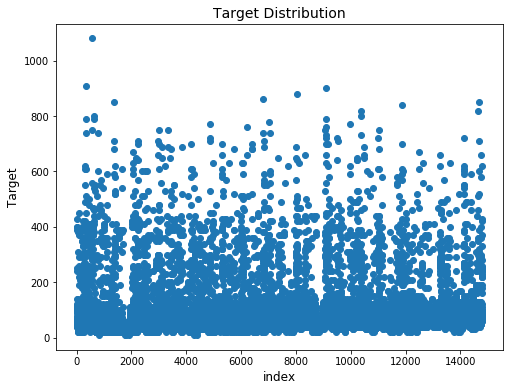

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(range(output.shape[0]), np.sort(output.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

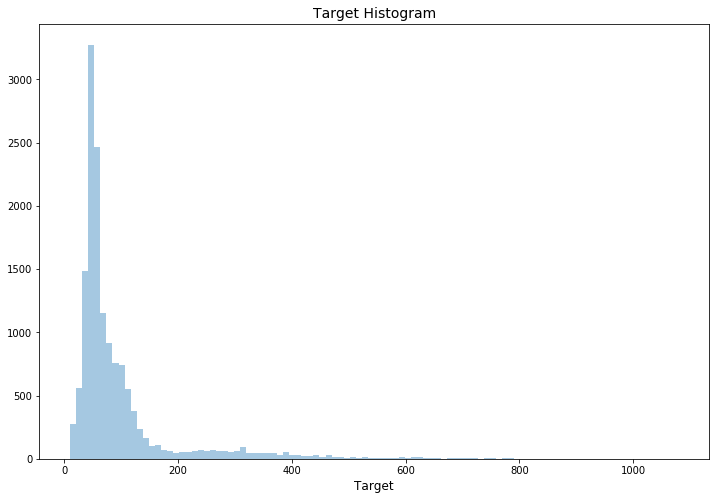

In [32]:
plt.figure(figsize=(12,8))
sns.distplot(output.values, bins=100, kde=False)
plt.xlabel('Target',fontsize=12)
plt.title('Target Histogram', fontsize=14)
plt.show()

In [33]:
missing_df = input_vars.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [34]:
dtype_df = input_vars.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,float64,24


In [35]:
unique_df = input_vars.nunique().reset_index()
unique_df.columns = ['col_name','unique_count']
constant_df = unique_df[unique_df['unique_count']==1]
constant_df.shape

(0, 2)

In [38]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

In [39]:
labels = []
values = []
for col in input_vars.columns:
    labels.append(col)
    values.append(spearmanr(input_vars[col].values, output.values)[0])

In [41]:
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

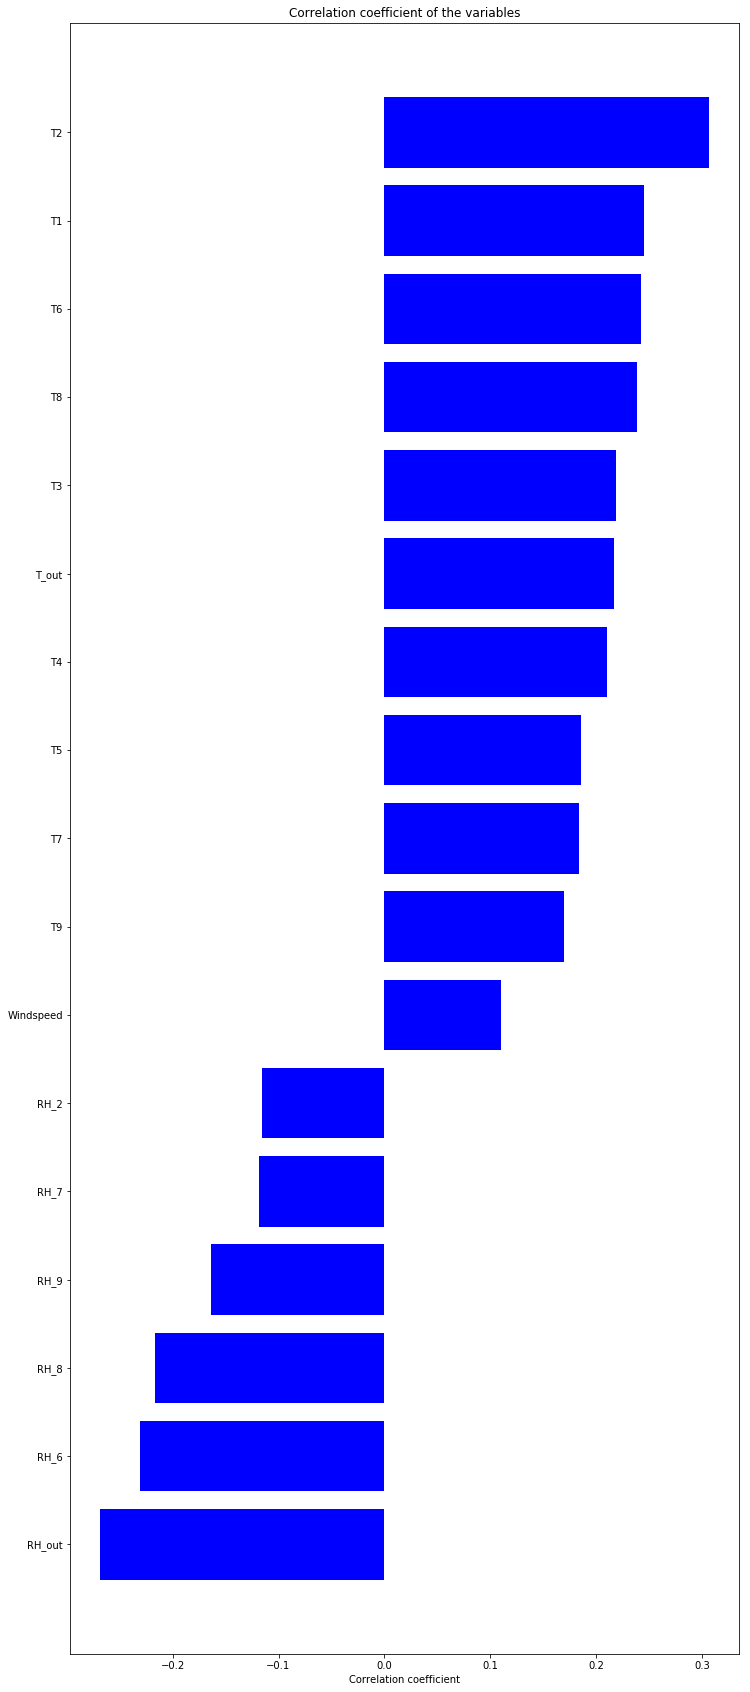

In [42]:
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig,ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

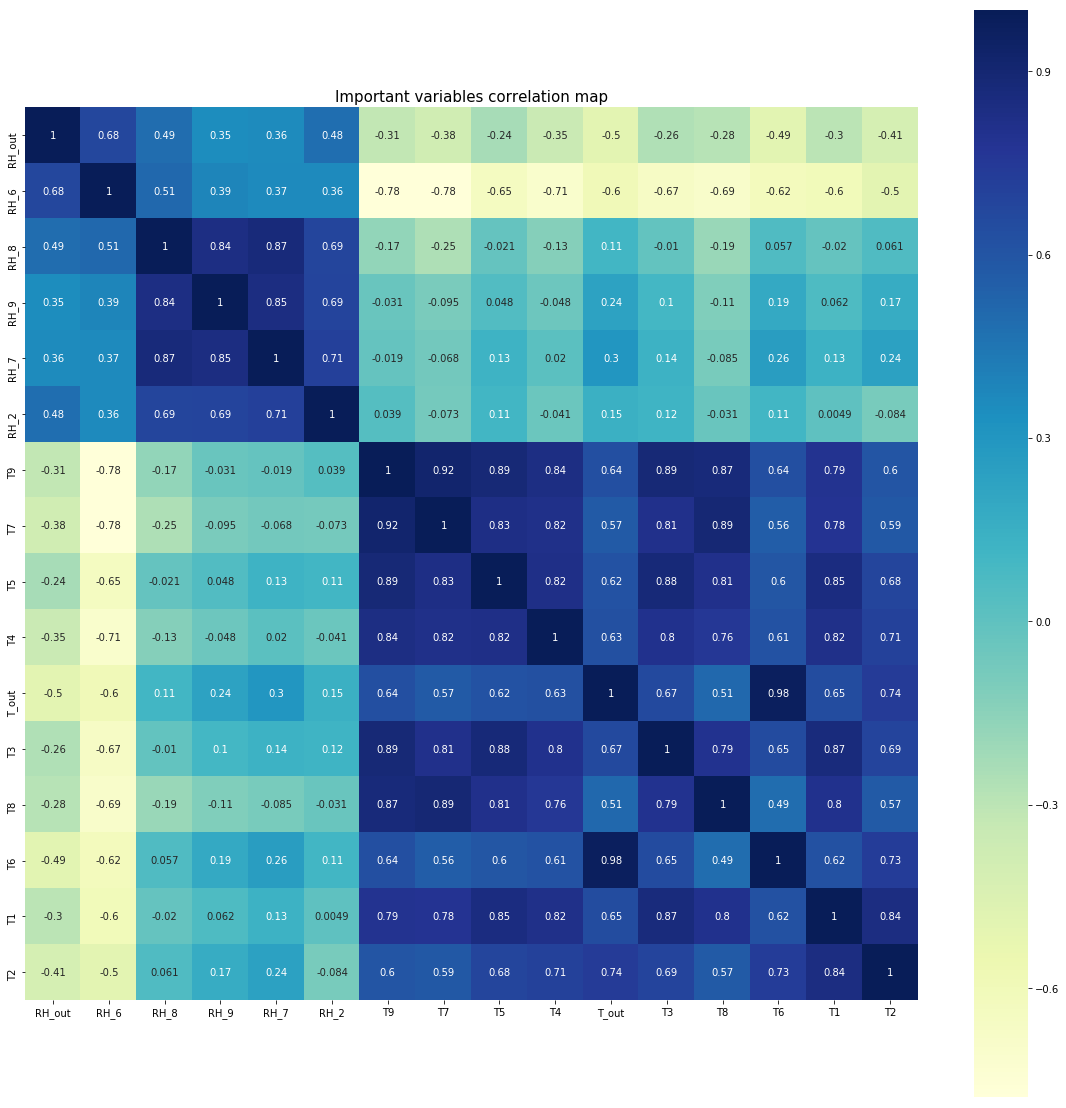

In [43]:
cols_to_use = corr_df[(corr_df['corr_values']>0.11) | (corr_df['corr_values']<-0.11)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f,ax = plt.subplots(figsize=(20,20))

sns.heatmap(corrmat, vmax=1., square=True, cmap = 'YlGnBu', annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [45]:
train_X  = input_vars.drop(constant_df.col_name.tolist(), axis=1)
#test_X = test_df.drop(constant_df.col_name.tolist() + ["ID"], axis=1)
train_y = output.values

In [48]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=20,
          max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

In [49]:
feature_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

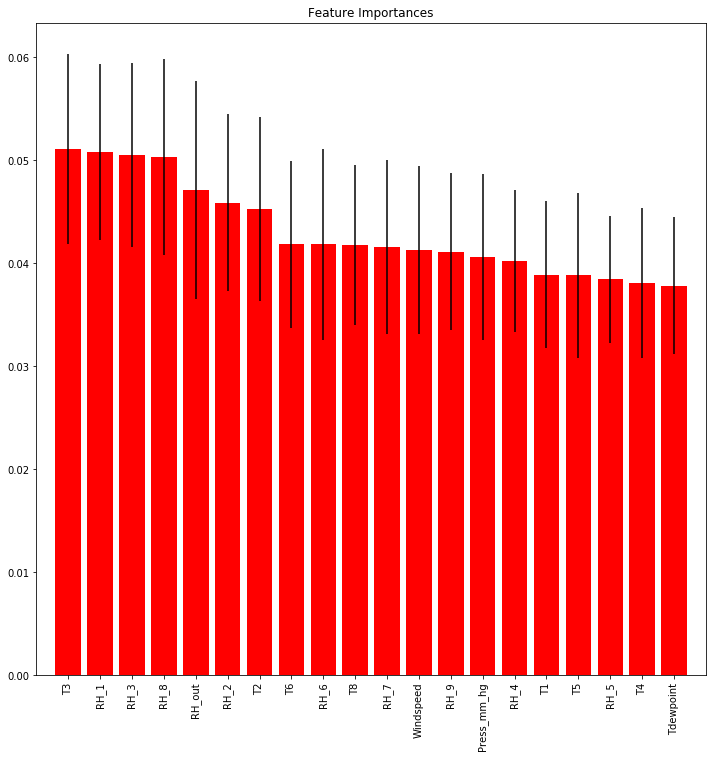

In [50]:
plt.figure(figsize=(12,12))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], color='r', yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [52]:
from sklearn.linear_model import LinearRegression

In [57]:
X_train = input_vars
y_train = output

In [58]:
benchmark_model = LinearRegression()
benchmark_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
test_data = pd.read_csv('test.csv')

In [64]:
X_test = test_data[temp_cols + rho_cols + weather_cols]
y_test = test_data[target]

In [ ]:
benchmark_model.score(X_train,y_trainq)